# Vehicle Detection and Tracking

In [1]:
import os
import glob
import numpy as np


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time

import pickle

import imageio

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data Read

In [2]:
# Data reading


# Vehicle Images Read

path_v     = glob.glob('vehicles/*/*.png')


cars=[]

for img_name_v in range(len(path_v)):
    cars.append(path_v[img_name_v])

with open ('cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn+ '\n')    

print ('Number of Vehicle Images found:', len(cars))        
        

Number of Vehicle Images found: 8792


In [3]:
# Non-Vehicle Images Read

path_n    = glob.glob('non-vehicles/*.png')

non_cars        = []


for img_name_n in range(len(path_n)):
    non_cars.append(path_n[img_name_n])
    
with open ('non-cars.txt', 'w') as g:
    for gn in non_cars:
        g.write(gn+ '\n')
        
print ('Number of Non-Vehicle Images found:', len(non_cars))        

Number of Non-Vehicle Images found: 8968


## HOG Feature Extraction

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True,block_norm= 'L1', 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True,block_norm= 'L1', 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [5]:
ind = np.random.randint(0, len(cars))
image_test = mpimg.imread(cars[ind])

In [48]:
gray = cv2.cvtColor(image_test, cv2.COLOR_RGB2GRAY)

In [49]:
features_test, hog_image_test = get_hog_features(gray, orient= 9, pix_per_cell= 8, cell_per_block= 2, vis=True, feature_vec=True)

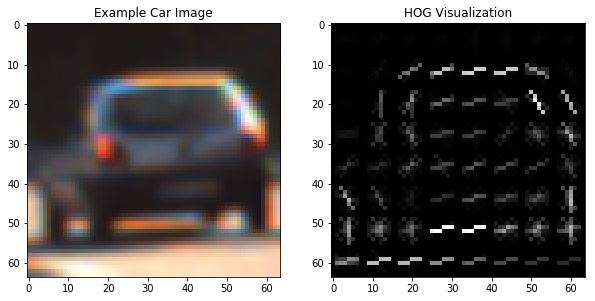

In [51]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image_test, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image_test, cmap='gray')
plt.title('HOG Visualization')
imageio.imwrite(path_plot + 'hog.jpg',  np.dstack((hog_image_test*100,hog_image_test*30,hog_image_test*40)))
imageio.imwrite(path_plot + 'car_hog.jpg', image_test)

## Spatial Feature Extraction

In [9]:
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 


## Color Histogram Feature Extraction

In [10]:
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

## Feature Extraction From A File With Multiple Images

In [15]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """ Extracts features from a list of images given certain parameters.
    Uses the bin_spatial and color_hist functions.
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = image.astype(np.float32)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        feature_image = feature_image.astype(np.float32)/255
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Classifier

In [16]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell =16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel ='ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat =False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print( 'Car samples: ', len(car_features))
notcar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print( 'Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

X_scaler = StandardScaler().fit(X_train) # Fit a per-column scaler

X_train =  X_scaler.transform(X_train)
X_test  =  X_scaler.transform(X_test)# Apply the scaler to X

 # Define the labels vector

# Split up data into randomized training and test sets


print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
t=time.time()
svc = LinearSVC(loss='hinge') # Use a linear SVC 
# Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
print(round(time.time()-t, 4), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

C:\01_Projekte\01_SDC_E\Miniconda\envs\car-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car samples:  8792
Notcar samples:  8968
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1236
2.5667 Seconds to train SVC...
Test Accuracy of SVC =  0.9755


## Feature Extraction From A Single Image

In [17]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """ Extracts features from a single image window.
    Similar to extract_features but this is just for one image and not
    a list of images.
    """
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    
    feature_image = feature_image.astype(np.float32)/255
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Visualize results

In [18]:
def visualize (fig,rows,cols,imgs,titles):
    for i,img in enumerate (imgs):
        plt.subplot(rows,cols,i+1)
        fig.subplots_adjust(hspace = .3, wspace=.0002)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims<3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            plt.axis('off')

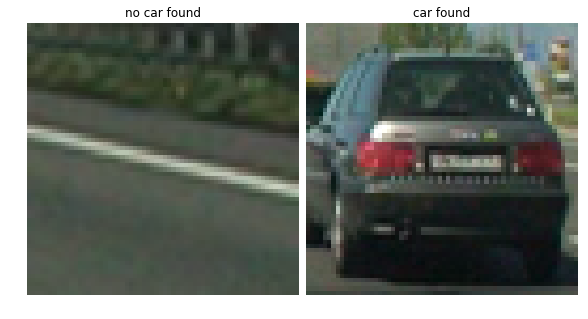

In [52]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell =16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel ='ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat =False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


out_images=[]
out_titles=[]

path_plot = ('output_images/')

ind = np.random.randint(0, len(non_cars))
image_test = mpimg.imread(non_cars[ind])
out_images.append(image_test)

ind = np.random.randint(0, len(cars))
image_test = mpimg.imread(cars[ind])
out_images.append(image_test)

for i in range(2): 
    features = single_img_features(out_images[i], color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
    test_features = X_scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
    prediction = svc.predict(test_features)
    confidence = svc.decision_function(test_features)       

    if prediction == 1:
        out_titles.append('car found')
        imageio.imwrite(path_plot + 'car.jpg', out_images[i])
    else:
        out_titles.append('no car found')
        imageio.imwrite(path_plot + 'no_car.jpg', out_images[i])

fig = plt.figure(figsize=(10,5))
visualize(fig,1,2,out_images,out_titles)                              

### Draw Boxes

In [20]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for i in bboxes:
        cv2.rectangle(draw_img,i[0],i[1],color,thick)# draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img

In [21]:
def color_conversion(img, c_type= 'YCrCb'):
   
    if c_type == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif c_type == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif c_type == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif c_type == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif c_type == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb) 
    
    else: feature_image = np.copy(img)
    
    return feature_image    

In [22]:
def find_cars(image,scale,ystart,ystop):
    
    
    orient = 11  # HOG orientations
    pix_per_cell =16 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel ='ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat =False # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    
    
    min_confidence = 0.4
    
    img_boxes =[]
    
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    heatmap = np.zeros_like(image[:,:,0])
    img_tosearch = image[ystart:ystop,:,:]
    ctrans_tosearch = color_conversion(img_tosearch, c_type= 'YCrCb')
    
    ctrans_tosearch = ctrans_tosearch.astype(np.float32)/255
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]//scale),np.int(imshape[0]//scale))) 

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1 
    nfeat_per_block = orient*cell_per_block**2


    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # How many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step


         # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
                    # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                    # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform( hog_features.reshape(1, -1)) 
            confidence = svc.decision_function(test_features)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 and confidence > min_confidence:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_image,(xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw]+=1

    return  img_boxes


In [23]:
def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [24]:
def apply_threshold(heatmap,threshold):
    heatmap[heatmap <threshold]=0
    return heatmap


In [25]:
from scipy.ndimage.measurements import label

In [28]:
def process_image(image, show_heat_map = False):
    
   
    threshold = 3
    
    car_boxes=[]
    heat_map_img = np.zeros_like(image[:,:,0])
    

    ystart = 380
    ystop  = 550
    scale  = 1.0
    
    car_boxes=(find_cars(image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))

    ystart = 380
    ystop  = 580
    scale  = 1.2
    
    car_boxes=(find_cars(image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 380
    ystop  = 600
    scale  = 1.25
    
    
    car_boxes=(find_cars(image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 380
    ystop  = 650
    scale  = 1.4
    
    car_boxes=(find_cars(image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 370
    ystop  = 550
    scale  = 1.5
    
    car_boxes=(find_cars(image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 380
    ystop  = 720
    scale  = 1.6
    
    car_boxes=(find_cars(image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 380
    ystop  = 720
    scale  = 1.8
    
    car_boxes=(find_cars(image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
     
    th_heat_map = apply_threshold(heat_map_img,threshold) 
    labels = label(th_heat_map)
    #print(labels[1])
    draw_image = draw_labeled_bound_boxes(np.copy(image),labels)
    
    if show_heat_map == False:
        return draw_image
    
    else:
        return draw_image,th_heat_map

In [29]:
def draw_labeled_bound_boxes(img,labels,give_boxes=False):
    
    for car_number in range(1, labels[1]+1):
        nonzero   = (labels[0] == car_number).nonzero()
        nonzeroy  = np.array(nonzero[0])
        nonzerox  = np.array(nonzero[1])
        bound_box = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        bound_box_center =(((np.min(nonzerox)+ np.max(nonzerox))/2),((np.max(nonzeroy)+np.min(nonzeroy))/2))
        cv2.rectangle(img,bound_box[0],bound_box[1],(0,0,255),6)
        #print(bound_box_center)
    if give_boxes == False:    
        return img
    else:
        return bound_box
    

C:\01_Projekte\01_SDC_E\Miniconda\envs\car-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


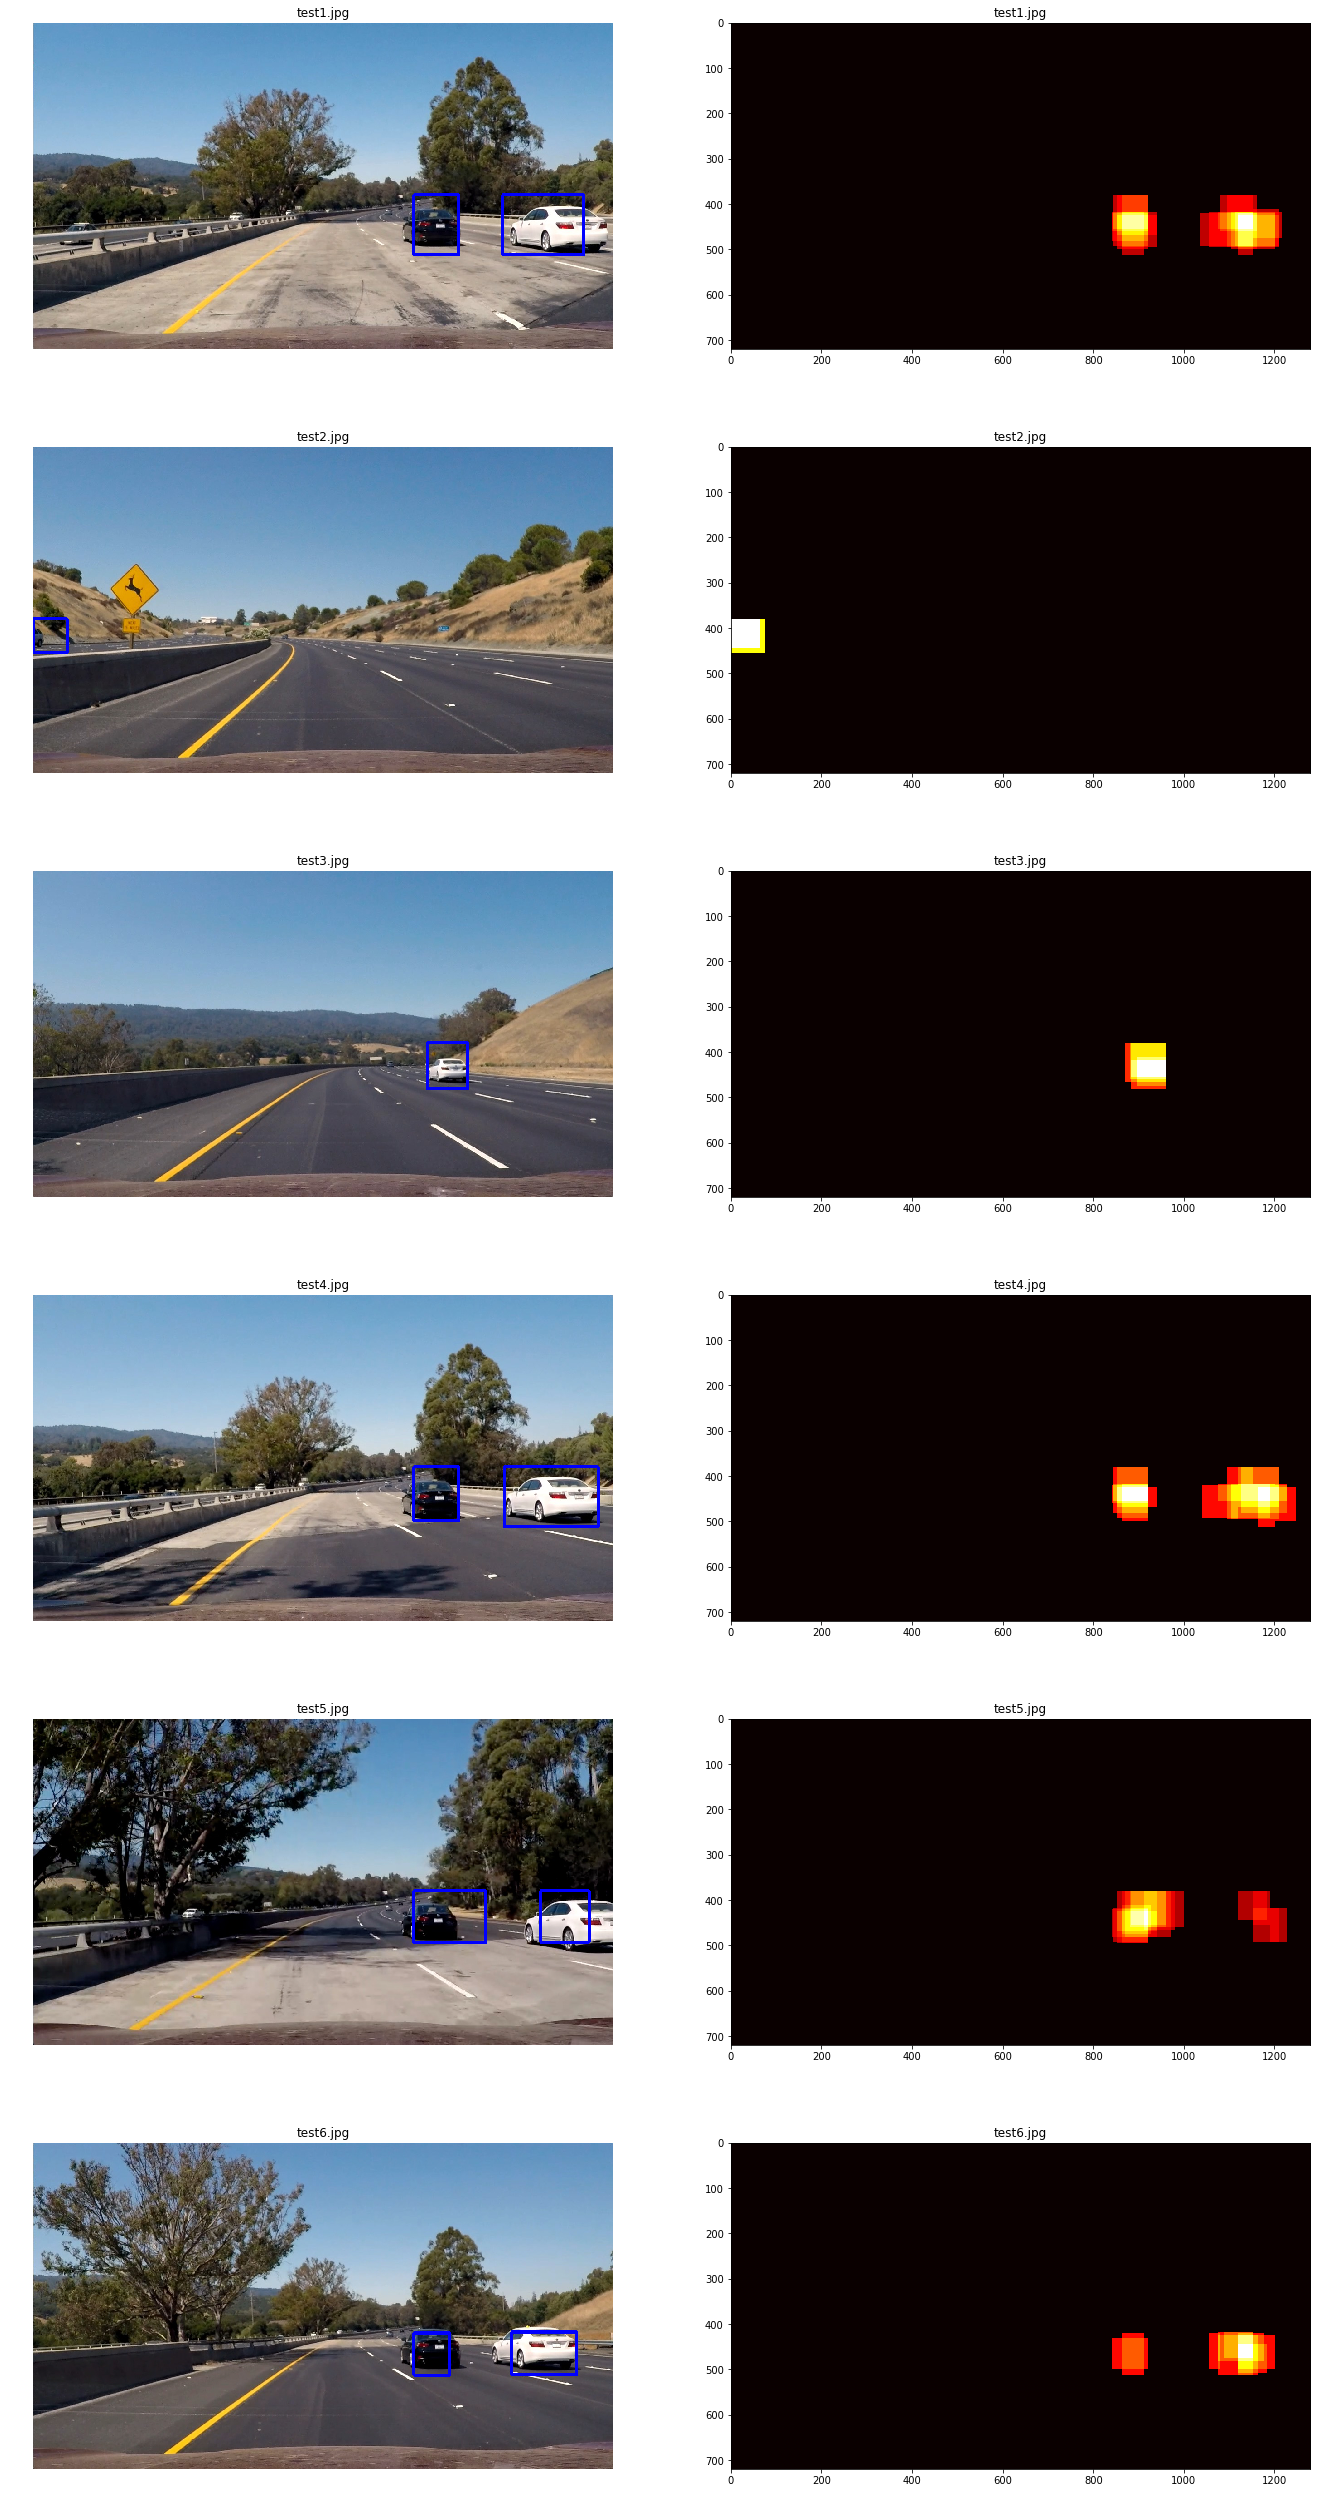

In [30]:
out_images =[]
out_titles =[]

a=0

for image_p in glob.glob('test_images/test*.jpg'):
    
    image = mpimg.imread(image_p)
    
    cars_found,heat_img = process_image(image,show_heat_map = True)
    out_images.append(cars_found)
    out_titles.append(image_p[-9:])
    out_images.append(heat_img)
    out_titles.append(image_p[-9:])
    a+=1
    imageio.imwrite(path_plot + 'test' +str(a) + '.jpg', cars_found)
    imageio.imwrite(path_plot + 'heatmap_test' +str(a) + '.jpg', np.dstack((heat_img*100,heat_img*30,heat_img*40)))
    
fig = plt.figure(figsize=(25,45))
visualize(fig,6,2,out_images,out_titles)

In [33]:
class Vehicle_detected():
    def __init__(self):
        self.labeled_detections = [] 
        
        

    def add_detections(self, detection):
        self.labeled_detections.append(detection)
        if len(self.labeled_detections)> 20:
            self.labeled_detections = self.labeled_detections[-20:]


In [34]:
def process_video_image(v_image, show_heat_map = False):
    
   
    threshold = 3
    
    car_boxes=[]
    heat_map_img = np.zeros_like(image[:,:,0])
    history_heat_map_img = np.zeros_like(image[:,:,0])
    
    ystart = 380
    ystop  = 550
    scale  = 1.0
    
    car_boxes=(find_cars(v_image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))

    ystart = 380
    ystop  = 580
    scale  = 1.2
    
    car_boxes=(find_cars(v_image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 380
    ystop  = 600
    scale  = 1.25
    
    
    car_boxes=(find_cars(v_image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 390
    ystop  = 550
    scale  = 1.3
    
    
    car_boxes=(find_cars(v_image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    
    ystart = 380
    ystop  = 650
    scale  = 1.4
    
    car_boxes=(find_cars(v_image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 370
    ystop  = 550
    scale  = 1.5
    
    car_boxes=(find_cars(v_image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 380
    ystop  = 720
    scale  = 1.8
    
    car_boxes=(find_cars(v_image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    ystart = 380
    ystop  = 720
    scale  = 2.2
    
    car_boxes=(find_cars(v_image,scale,ystart,ystop))
    add_heat(heat_map_img, car_boxes)
    #print(np.max(heat_map_img))
    
    
    th_heat_map = apply_threshold(heat_map_img,threshold) 

    
    if th_heat_map is not None:
    
        car.add_detections(th_heat_map)
    
    history_threshold = 25
    #print(len(car.labeled_detections))
    for detect in car.labeled_detections:
        history_heat_map_img += detect
        
    th_history_heat_map_img = apply_threshold(history_heat_map_img,history_threshold)
    
    labels = label(th_history_heat_map_img)
    #labels =label(th_heat_map)
    #print(len(labels))
    draw_image = draw_labeled_bound_boxes(np.copy(v_image),labels,give_boxes=False)
    
    if show_heat_map == False:
        return draw_image
    
    else:
        return draw_image,th_heat_map

In [39]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

car= Vehicle_detected()


test_output = 'test_9.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_video_image)
test_clip.write_videofile(test_output,audio=False)



[MoviePy] >>>> Building video test_9.mp4
[MoviePy] Writing video test_9.mp4


100%|█████████████████████████████████████▉| 1260/1261 [26:51<00:01,  1.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_9.mp4 



In [41]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('test_9.mp4'))